demo for class


In [ ]:
# import os
# import torch
# import itertools
# os.environ['TORCH'] = torch.__version__
# os.environ['PYTHONWARNINGS'] = "ignore"
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install torch-geometric
# !pip3 install kmeans1d
# from torch_geometric.data import Data
# import torch.nn.functional as F
# from torch.nn import Linear
# import torch_geometric.transforms as T
# import sys
# import random
# import numpy as np
# import time
# import math
# import csv
# import datetime
# import math
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import pandas as pd
# import glob
# import random
# import torch.nn as nn
# import torch.optim as optim
# from collections import defaultdict
# from tqdm.notebook import tqdm
# from math import exp
# from chardet import detect
# from torch_geometric.nn.conv import MessagePassing
# from torch_geometric.utils import degree
# from sklearn import preprocessing as pp
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import scipy.sparse as sp
# from networkx.algorithms import bipartite
# import kmeans1d
# import copy
# from google.colab import drive

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-xpmbo7k_
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-xpmbo7k_
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 1260715041ad9bf7ba23a93e67f8371c1f0a3b5d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# --- 표준 라이브러리 ---
import os, sys, math, time, random, copy, glob, csv, datetime, itertools
from collections import defaultdict

# --- 과학 연산 / 시각화 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.sparse as sp

# --- PyTorch & PyG ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

# --- 기타 ---
from tqdm import tqdm
from chardet import detect
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import bipartite
import kmeans1d

# --- Device 선택 (Apple Silicon M4) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# MPS 미지원 연산 자동 CPU fallback 허용
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

print("Using device:", device)

In [23]:
# hyperparameters
latent_dim =8   # length of user/item embedding
num_layer = 5   # num.hop neighbor
rating_threshold = 4
batch_size = 4
epochs = 500
learning_rate = 0.0001
decay = 0.0001
topK = 3 # num. top recommend
dropout = 0.2
sample_rate = 0  # test size, train whole set

df = pd.read_csv('3e.csv')   #('movielens.csv')
print("*"*50)
print("Original dataset info.")
user_ids = sorted(df['user'].unique())
item_ids = sorted(df['item'].unique())
print("  Number of users = ", len(user_ids))
print("  Number of items = ", len(item_ids))
print("  Number of ratings = ", len(df))
print("*"*50)
print("After rating filtering")
print("  Rating threshhold = ", rating_threshold)
df = df[df['rating']>=rating_threshold]  # consider only rating >= threshold
user_ids = sorted(df['user'].unique())
item_ids = sorted(df['item'].unique())
print("  Number of users = ", len(user_ids))
print("  Number of items = ", len(item_ids))
print("  Number of ratings = ", len(df))

**************************************************
Original dataset info.
  Number of users =  7
  Number of items =  7
  Number of ratings =  20
**************************************************
After rating filtering
  Rating threshhold =  4
  Number of users =  7
  Number of items =  7
  Number of ratings =  20


LightGCN link prediction


/tmp/ipython-input-3887894537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['user_idx'] = le_user.fit_transform(df_train['user'].values)
/tmp/ipython-input-3887894537.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['item_idx'] = le_item.fit_transform(df_train['item'].values)


  0%|          | 0/500 [00:00<?, ?it/s]

          1         2         3         4         5         6         7
a  0.272603  0.626233 -0.534831 -0.454983  0.715822  0.576866 -0.657847
b -0.171215 -0.593156  0.694799  0.596824 -0.674386 -0.587070  0.814671
c -0.227772 -0.743163  0.813076  0.748663 -0.851213 -0.751882  0.969857
d  0.323910  0.754000 -0.677962 -0.577051  0.865621  0.709471 -0.827086
e -0.075586 -0.430597  0.563520  0.544567 -0.483912 -0.463991  0.661753
f  0.290652  0.615603 -0.530953 -0.432481  0.705235  0.566926 -0.647459
g  0.196783  0.534683 -0.482581 -0.445374  0.641426  0.524022 -0.598744


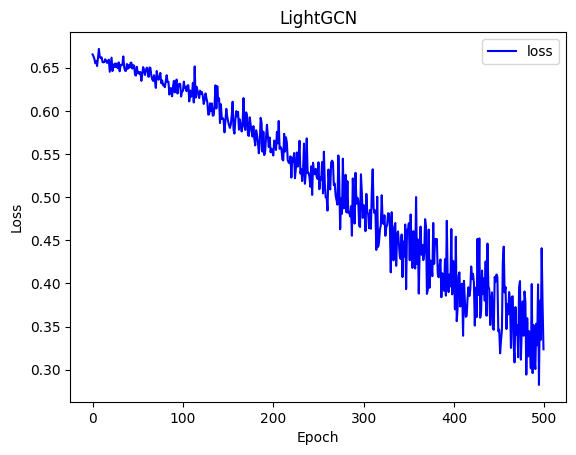

In [24]:
rand_indices = np.random.permutation(range(df.shape[0]))
train_size = math.ceil(len(df)*(1-sample_rate))
df_train = df.iloc[rand_indices[:train_size]]

le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
df_train['user_idx'] = le_user.fit_transform(df_train['user'].values)
df_train['item_idx'] = le_item.fit_transform(df_train['item'].values)
df_train = df_train.sort_values(by=['user', 'item'], ascending=[True, True])
user_ids = sorted(df_train['user'].unique())
item_ids = sorted(df_train['item'].unique())
num_user = len(user_ids)
num_item = len(item_ids)

def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + posEmb0.norm().pow(2) + negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss


def data_loader(data, batch_size, n_usr, n_itm):
    interected_items_df = data.groupby('user_idx')['item_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
    users_df = pd.DataFrame(users, columns = ['users'])
    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_idx', right_on = 'users')
    pos_items = interected_items_df['item_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)


class LightGCN(nn.Module):
    def __init__(self, data, n_user, n_item, n_layers, latent_dim=32):
        super(LightGCN, self).__init__()
        print("LightGCN link prediction")
        self.data = data
        self.num_user = n_user
        self.num_item = n_item
        self.num_layer = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.num_user + self.num_item, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.num_user, self.num_item), dtype = np.float32)
        R[self.data['user_idx'], self.data['item_idx']] = 1.0

        adj_mat = sp.dok_matrix((self.num_user + self.num_item, self.num_user + self.num_item), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: self.num_user, self.num_user :] = R
        adj_mat[self.num_user :, : self.num_user] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Below Code is toconvert the dok_matrix to sparse tensor.
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape
        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor


    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.num_layer):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [self.num_user, self.num_item])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [self.num_user, self.num_item])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed


    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0


# train model
model = LightGCN(df_train, num_user, num_item, num_layer, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_list_epoch = []
for epoch in tqdm(range(epochs)):
    n_batch = int(len(df_train)/batch_size)
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []

    model.train()
    for batch_idx in range(n_batch):
        optimizer.zero_grad()
        users, pos_items, neg_items = data_loader(df_train, batch_size, num_user, num_item)
        users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.forward(users, pos_items, neg_items)
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
        reg_loss = decay * reg_loss
        final_loss = mf_loss + reg_loss
        final_loss.backward()
        optimizer.step()
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())

    model.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = model.propagate_through_layers()

    loss_list_epoch.append(round(np.mean(final_loss_list),4))


score = torch.matmul(final_user_Embed, torch.transpose(final_item_Embed,0, 1))
df_score = pd.DataFrame(score, index=user_ids, columns = item_ids)
print(df_score)


# loss graph
losses_np = np.array(loss_list_epoch)
epoch_range = np.arange(1,epochs)
plt.plot(losses_np, color='blue', label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
def user_info(user, df_train, df_score, item_ids):
    list_select = []
    list_score = []
    print("\n user ", user)
    for i, v in enumerate(item_ids):
        list_score.append(df_score.loc[user][v])
        if ((df_train['user']==user) & (df_train['item']==v)).any():
            list_select.append(1)
        else:
            list_select.append(0)

    return list_select, list_score


print("*"*50)
print("\n  추천 목록")
recom_dic = {}
for u in user_ids:
    list_select, list_score = user_info(u, df_train, df_score, item_ids)
    list_recom, centroids = kmeans1d.cluster(list_score, 2)

    recom_ok = []
    recom_no = []
    for ir in range(len(list_recom)):
        if list_select[ir]==0 and list_recom[ir]==1:
            recom_ok.append(item_ids[ir])
            print("  buy",item_ids[ir])
        if list_select[ir]==1 and list_recom[ir]==0:
            recom_no.append(item_ids[ir])
            print("  sell",item_ids[ir])

    if len(recom_ok) > 0:
        print("  recommend buy ", len(recom_ok),"items")
    if len(recom_no) > 0:
        print("  recommend sell ", len(recom_no),"items")


**************************************************

  추천 목록

 user  a

 user  b
  buy 4
  recommend buy  1 items

 user  c

 user  d
  buy 1
  recommend buy  1 items

 user  e
  sell 1
  buy 3
  recommend buy  1 items
  recommend sell  1 items

 user  f
  buy 6
  recommend buy  1 items

 user  g
  buy 1
  buy 2
  recommend buy  2 items
